# Контрольная работа #1
В этой контрольной работе разрешается пользоваться пакетом `cvxpy`, линейной алгеброй из `numpy/scipy`, но не `sklearn`.
## Задача #1 (2б): проекция на линейное подпространство
Дана невырожденная матрица $A\in\mathbb{R}^{m\times n}$, $m<n$, вектор $b\in \mathbb{R}^{m}$ и точка $y\in\mathbb{R}^n$. Требуется найти точку $x$ такую, что $Ax=b$ и при этом $\|x-y\|$ принимает минильное значение.

In [3]:
import numpy as np
import scipy as sc
import scipy.linalg
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [18]:
def linear_subspace_projection(A, b, y):
    """
    Возвращает точку x: Ax=b, ||x-y||->min
    
    Args:
        A: ndarray(m, n)
        b: ndarray(m, 1)
        y: ndarray(n, 1)
        
    Returns:
        x: ndarray(n, 1)
    """
    n = y.shape[0]
    x = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(x - y.flatten()))
    constraints = [A @ x == b]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return x.value

In [19]:
def show_projection():
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
        
    A = np.random.rand(1, 2)
    b = 0.5
    
    y = np.random.rand(2, 1)
    
    x = linear_subspace_projection(A, b, y)
    ax.scatter([y[0], x[0]], [y[1], x[1]], color='black')
    ax.plot([y[0], x[0]], [y[1], x[1]], color='grey', linestyle='--')
    ax.text(x[0] - 0.1, x[1] - 0.1, 'x', fontsize = 15)
    ax.text(y[0] + 0.1, y[1] + 0.1, 'y', fontsize = 15)
    delta = 0.05
    p = np.arange(-1.5, 1.5, delta)
    q = np.arange(-1.5, 1.5, delta)
    X, Y = np.meshgrid(p, q)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i][j] = A @ np.array([X[i][j], Y[i][j]])
    CS = ax.contour(X, Y, Z, [b], colors=['blue'])
    plt.close(fig)
    return fig

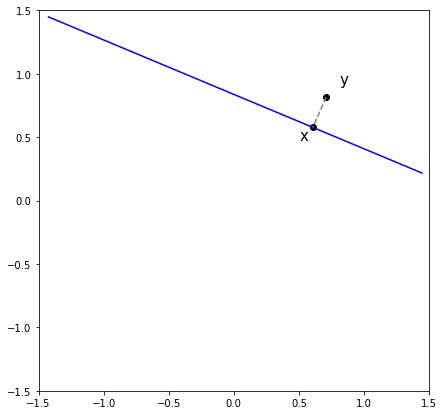

In [65]:
show_projection()

## Задача #2 (4б): логистическая регрессия
В этой задаче вам предлагается обучить модель линейной регрессии: дан набор точек $x_i\in \mathbb{R}^n$ и соответствующих им меток $y_i\in \{0, 1\}$. Нужно найти гиперплоскость как можно лучше разделяющую точки с метками $0$ от точек с метками $1$. В логистической регрессии обучается модель-предиктор:
$$
f(x, \theta)=\sigma (\theta^Tx)
$$
где
$$
\sigma(t)=\frac{1}{1+e^{-t}}.
$$
$\theta$ соответствует параметрам гиперплоскости, вдоль которой идет разделение. Величина $f(x, \theta)$ трактуется как вероятность принадлежности к классу с меткой $1$. Критерий максимального правдоподобия в данном случае эквивалентен минимизации кросс-энтропии
$$
\mathcal{J}(x, y, \theta)=-\frac{1}{m}\sum_{i=1}^m\left[y_i\log f(x_i, \theta)+(1-y_i)(1-\log(1-f(x_i, \theta)))\right]
$$
Стоит отметить, что
$$
\begin{array}{rl}
\frac{d}{dt}\sigma(t)&=\left(\frac{1}{1+e^{-t}}\right)'\\
&=-\frac{-e^{-t}}{(1+e^{-t})^2}\\
&=(1-\sigma(t))\sigma(t)
\end{array}
$$
и, соответственно
$$
\begin{array}{rl}
\nabla_\theta\mathcal{J}(x, y, \theta)&=-\frac{1}{m}\sum_{i=1}^m\left[y_i\frac{1}{\sigma(\theta^Tx_i)}(1-\sigma(\theta^Tx_i))\sigma(\theta^Tx_i)x_i-(1-y_i)\frac{1}{1-\sigma(\theta^Tx_i)}(1-\sigma(\theta^Tx_i))\sigma(\theta^Tx_i)x_i\right]\\
&=-\frac{1}{m}\sum_{i=1}^m\left[y_i(1-\sigma(\theta^Tx_i))x_i-(1-y_i)\sigma(\theta^Tx_i)x_i\right]\\
&=-\frac{1}{m}\sum_{i=1}^m\left[(y_i-\sigma(\theta^Tx_i))x_i\right]
\end{array}
$$
Реулизуйте обучение логистической регрессии с помощью градиентного спуска для смещенной логистической регрессии, т.е. для
$$
f(x, \theta, \beta)=\sigma(\theta^Tx+\beta)
$$

In [63]:
def logistic_regression(x, y, alpha, iters):
    """
    Возвращает оптимальные параметры логистической регрессии theta, beta, полученные минимизацией кросс-энтропии
    
    Args:
        x: ndarray(m, n) -- матрица, каждая строка которой является точкой, которые отделяются регрессией
        y: ndarray(m)    -- вектор-столбец, i-ый элемент которого соответствует метке i-ой строке в x,
                            принимает значения 0 или 1
        alpha: float -- размер шага для градиентного спуска
        iters: int   -- количество итераций градиентного спуска
    Returns:
        theta: ndarray(n)
        beta: float/ndarray(1) -- параметры регрессии
    """
    m, n = x.shape
    x_ext = np.concatenate((x, np.ones((m, 1))), axis=1)
    
    def sigma(x):
        return 1/(1 + np.exp(-x))
    
    theta = np.zeros(n + 1)
    
    for k in range(iters):
        grad = np.zeros(n + 1)
        for i in range(m):
            grad += (y[i] - sigma(np.dot(theta, x_ext[i]))) * x_ext[i]
        grad *= -1 / m
        theta -= alpha * grad
        
    return theta[:-1], theta[-1]

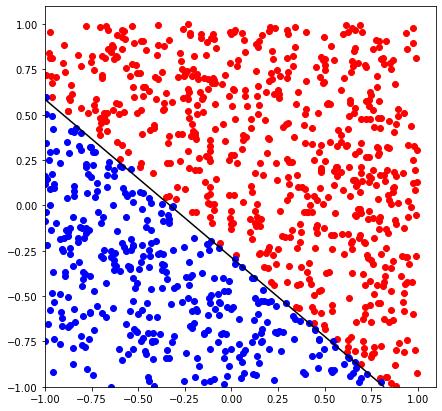

In [64]:
fig, ax = plt.subplots(figsize=[7, 7])
n = 2
m = 1000
x = 2 * np.random.rand(m, n) - 1
a = np.random.rand(n)
b = 0.2

y = (np.sign(x @ a + np.ones(m) * b) + 1) / 2

theta, beta = logistic_regression(x, y, 0.05, 1000)

ax.scatter(x[y > 0,0], x[y > 0,1], color='red')
ax.scatter(x[y == 0,0], x[y == 0,1], color='blue')
#Level contours
delta = 0.025
x_ = np.arange(-1, 1, delta)
y_ = np.arange(-1, 1, delta)
X, Y = np.meshgrid(x_, y_)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i][j] = theta @ np.array([X[i][j], Y[i][j]]) + beta
        
CS = ax.contour(X, Y, Z, [0], colors=['black'])
plt.close(fig)
fig

## Задача #3 (3б): линейное программирование
В этой задаче вам предлагается решить задачу линейного программирования в стандартной форме
$$
\begin{array}{ll}
\mbox{минимизировать } &~ c^Tx\\
\mbox{при условии } &~ Ax\leq b \\
&~x\geq 0
\end{array}
$$

In [84]:
def solve_lp(A, b, c):
    x = cp.Variable(A.shape[1])
    objective = cp.Minimize(c @ x)
    constraints = [A @ x <= b, x >= 0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    return x.value

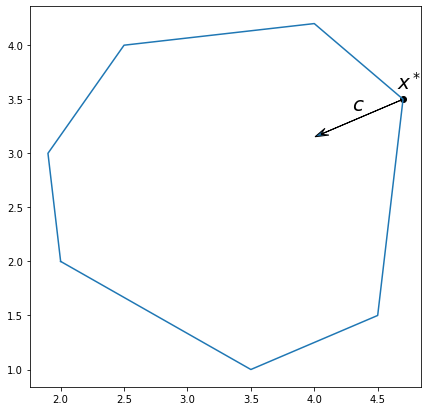

In [85]:
# from two points defines the coefficients a, b, c such that a line ax+by=c goes through these points 
def get_line(x1, x2):
    a = x1[1] - x2[1]
    b = x2[0] - x1[0]
    c = a * x1[0] + b * x1[1]
    return a, b, c

vertices = [(2.0, 2.0), (1.9, 3.0), (2.5, 4.0), (4.0, 4.2), (4.7, 3.5), (4.5, 1.5), (3.5, 1.0), (2.0, 2.0)]
A = []
b = []

fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(vertices) - 1):
    a_, b_, c_ = get_line(vertices[i], vertices[i + 1])
    A.append([a_, b_])
    b.append(c_)
    #print(f'{float(a):6.2} * x + {float(b):4.2} * y <= {float(a):4.2}')
A = np.array(A)
b = np.array(b)
direction = np.array([-2, -1]) # c
x = solve_lp(A, b, direction)
ax.plot([x for x, y in vertices], [y for x, y in vertices])
ax.scatter([x[0]], [x[1]], color='black')
ax.arrow(x[0], x[1], direction[0] * 0.3, direction[1] * 0.3, head_width=0.07, overhang=0.5)
ax.text(x[0] + direction[0] * 0.15 - 0.1, x[1] + direction[0] * 0.15 + 0.2, '$c$', fontsize=20)
ax.text(x[0] - 0.05, x[1] + 0.1, '$x^*$', fontsize=20)

plt.close(fig)
fig

## Задача #4 (3б): минимум максимума нескольких линейных функций
Дан набор одномерных линейных функций, требуется найти точку минимума максимума этих функций
$$
\max_{1\leq i\leq m}a_ix+b_i\rightarrow \min
$$

In [154]:
def min_max(a, b):
    eps = 1e-9
    n = len(a)
    lines = list(zip(a, b))
    lines.sort(key=lambda x: (x[0], -x[1]))
    
    def f(x):
        return max([a * x + b for (a, b) in lines])
    
    if lines[-1][0] < 0:
        return float('inf')
    if lines[0][0] > 0:
        return float('-inf')
    if lines[0][0] > -eps and lines[-1][0] < eps:
        return 0
    
    R = 1
    fcur = f(R)
    fnext = f(R * 2)
    while fcur >= fnext:
        fcur = fnext
        R *= 2
        fnext = f(R * 2)
    
    L = -1
    fcur = f(L)
    fnext = f(L * 2)
    while fcur >= fnext:
        fcur = fnext
        L *= 2
        fnext = f(L * 2)
    
    while R - L > eps:
        lmid = L + (R - L) / 3
        rmid = R - (R - L) / 3
        fl = f(lmid)
        fr = f(rmid)
        if fl < fr:
            R = rmid
        else:
            L = lmid
            
    return L

53


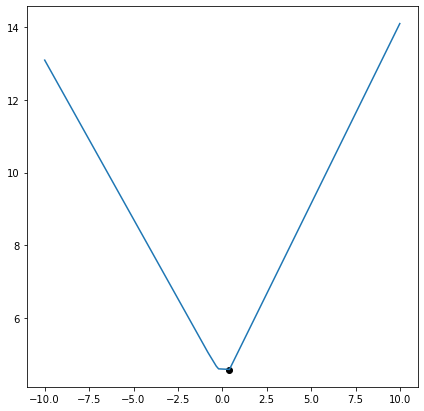

In [155]:
m = 100
a = np.random.rand(m) * 2 - 1
b = 5 * (np.random.rand(m) * 2 - 1)

q = np.arange(-10, 10, 0.01)

f = lambda x: max([a[i] * x + b[i] for i in range(a.shape[0])])

x = min_max(a, b)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(q, [f(x) for x in q])
ax.scatter([x], [f(x)], color='black')
plt.close(fig)
fig